### scheme: Exp

### Change method: change

### Markovlength: 50000

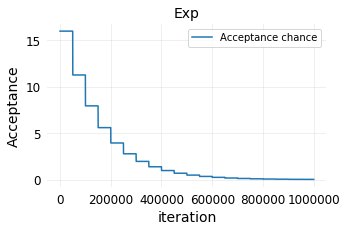

finished
Final score = 2745.8654071702995


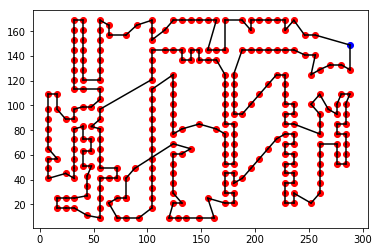

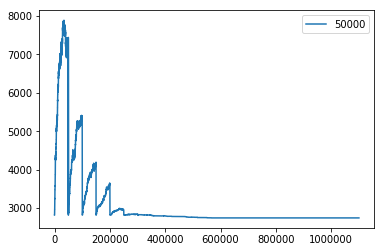

### Change method: 2-opt

### Markovlength: 50000

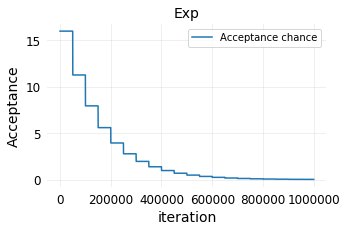

finished
Final score = 2752.1590326682676


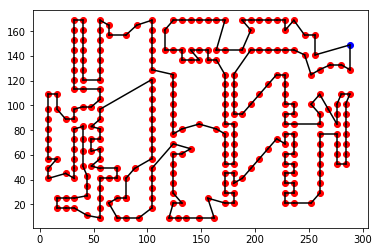

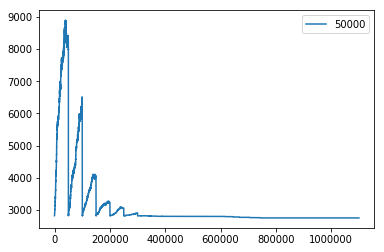

### scheme: Sigmoid

### Change method: change

### Markovlength: 50000

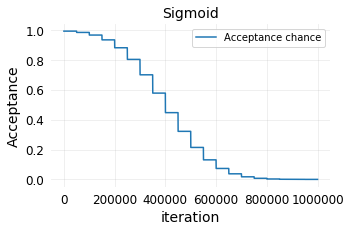

KeyboardInterrupt: 

In [3]:
import numpy as np
import scipy.spatial as sp
import matplotlib.pyplot as plt
import tkinter
import pandas as pd
import math
from progress.bar import Bar
from progress.bar import IncrementalBar
from numba import jit
from scipy.spatial import distance_matrix
import time
from IPython.display import IFrame, display, HTML, Markdown
import random


def printmd(string):
    display(Markdown(string))


def prettyfie(ax, x, y, title, legendYN='Yes'):

    # Remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(alpha=0.25)

    # Remove unnecessary ticks
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=True,
        left=False,
        right=False,
        labelleft=True)

    if legendYN == 'Yes':
        # Create legend and grid
        ax.legend(framealpha=1, shadow=True)
        ax.legend()

    # Set labels and title
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(y, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)


@jit
def getScheme_data(iters, plot="No", scheme="Sigmoid", markovChain=1):

    answer = []

    if scheme == "Sigmoid":
        linspace = np.linspace(0, 5, iters)
        for x in linspace:
            answer.append(0.5 +
                          math.erf((math.sqrt(math.pi) / 2) * (x - 2)) * -0.5)
    elif scheme == "Sigmoidvar":
        linspace = np.linspace(0, 4, iters)
        for x in linspace:
            answer.append(0.5 +
                          math.erf((math.sqrt(math.pi) / 2) * (x - 2)) * -0.5)
    elif scheme == "Exp":
        for x in range(iters):
            answer.append(16 * np.exp(-x / (iters / 7)))
    elif scheme == "Expvar":
        for x in range(iters):
            answer.append(
                max(
                    np.exp(-x / iters) -
                    1.05 * (1 / math.e),  #((1.5 * x) / iters)
                    0))
    elif scheme == "Hillclimb":
        for x in range(iters):
            answer.append(0)
    elif scheme == "Binary":
        for x in range(iters):
            if x < iters / 2:
                answer.append(1)
            else:
                answer.append(0)
    elif scheme == "Linear":
        for x in range(iters):
            answer.append(1.0 - x / iters)
    elif scheme == "Linearvar":
        for x in range(iters):
            answer.append(0.5 - 0.5 * x / iters)

    if plot == "Yes":
        plotanswer = np.repeat(answer, markovChain)
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
        ax.plot(plotanswer, label="Acceptance chance")
        ax.legend()
        prettyfie(ax, "iteration", "Acceptance", scheme, legendYN="Yes")
        plt.show()
    return np.array(answer)


@jit
def spawn(n):
    pointsdict = {}
    points = []
    for i in range(n):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        p = [x, y]
        pointsdict[i] = p
        points.append(i)
    return points, pointsdict


def scorecalc(n, points, pointsdict, distances):
    difs = 0
    for i in range(len(points) - 1):
        distance = distances[points[i]][points[i + 1]]
        difs += distance
    difs += distances[points[n - 1]][points[0]]
    return difs


def anneal(n, points, pointsdict, score, temp, distances, neighbour="change"):
    if neighbour == "change":
        new = list(np.copy(points))
        b1 = np.random.randint(0, len(points))
        pp = points[b1]
        nnn = max(3, int(temp * n))
        b2 = np.random.randint(0, len(points))
        ppp = new.pop(b1)
        new.insert(b2, pp)
    elif neighbour == "2-opt":
        b1 = np.random.randint(1, n)
        b2 = b1 + np.random.randint(2, n)
        switch = np.random.random()
        if switch < 0.5:
            new = np.concatenate((np.array(points[:b1], int),
                                  np.array(points[b1:b2][::-1], int),
                                  np.array(points[b2:], int)))
        else:
            new = np.concatenate((np.array(points[b2:][::-1], int),
                                  np.array(points[b1:b2], int),
                                  np.array(points[:b1][::-1], int)))

    newscore = scorecalc(n, new, pointsdict, distances)
    if temp > 0:
        chance = np.exp(-np.abs(newscore - score) / (1 * temp))
    else:
        chance = 0
    if newscore < score:
        return new, newscore
    elif np.random.uniform(0, 1) < chance:
        return new, newscore
    return points, score


@jit
def plot(n, points, pointsdict):
    x = []
    y = []
    for i in pointsdict:
        x.append(pointsdict[i][0])
        y.append(pointsdict[i][1])
    plt.scatter(x[1:], y[1:], color="red")
    plt.scatter(x[0], y[0], color="blue")
    for i in range(n - 1):
        a = pointsdict[points[i]]
        b = pointsdict[points[i + 1]]
        x = [a[0], b[0]]
        y = [a[1], b[1]]
        plt.plot(x, y, color="black")
    a = pointsdict[points[n - 1]]
    b = pointsdict[points[0]]
    x = [a[0], b[0]]
    y = [a[1], b[1]]
    plt.plot(x, y, color="black")
    plt.show()


@jit
def read_tsp_file(name):
    nodes = pd.read_csv(
        '%s.tsp.txt' % name,
        skiprows=6,
        skipfooter=1,
        delim_whitespace=True,
        header=None,
        names=('id', 'x', 'y'),
        engine='python')
    ids = nodes['id']
    xs = nodes['x']
    ys = nodes['y']
    points = list(range(len(ids)))
    pointsdict = {}
    for i in ids:
        pointsdict[i - 1] = [xs[i - 1], ys[i - 1]]
    return points, pointsdict


@jit
def read_opt_file(name):
    route = pd.read_csv(
        '%s.opt.tour.txt' % name,
        skiprows=4,
        skipfooter=1,
        header=None,
        delim_whitespace=True,
        names=('id', ),
        engine='python')
    ids = route['id']
    points = list(range(len(ids) - 1))
    for i in range(len(ids) - 1):
        points[i] = int(ids[i]) - 1
    return points


@jit
def run(n,
        iterations,
        iterations2,
        scheme,
        markovChain,
        plotScheme="No",
        pointsdict=None,
        points=None,
        neighbour="change"):
    if pointsdict == None:
        points, pointsdict = spawn(n)

    pointslist = []
    for point in points:
        pointslist.append(pointsdict[point])

    distances = distance_matrix(pointslist, pointslist)
    score = scorecalc(n, points, pointsdict, distances)
    temp = 1.0
    steps = []
    checklist = []
    schemeData = np.repeat(
        getScheme_data(
            math.ceil(iterations / markovChain),
            plot=plotScheme,
            scheme=scheme,
            markovChain=markovChain), markovChain)
    maxiterations = iterations + iterations2
    bar = IncrementalBar('Processing', max=maxiterations)
    bestscore = score
    bestpoints = list(np.copy(points))
    tempold = schemeData[0]
    for i in range(iterations):
        temp = schemeData[i]
        if temp != tempold:
            score = bestscore
            points = list(np.copy(bestpoints))
        points, scorenew = anneal(n, points, pointsdict, score, temp,
                                  distances, neighbour)
        steps.append(points)
        checklist.append(scorenew)
        if scorenew < bestscore:
            bestscore = scorenew
            bestpoints = list(np.copy(points))
        score = scorenew
        tempold = temp
        bar.next()
    for j in range(iterations2):
        score = bestscore
        points = list(np.copy(bestpoints))
        points, scorenew = anneal(n, points, pointsdict, score, 0, distances,
                                  neighbour)
        checklist.append(scorenew)
        score = scorenew
        bar.next()
    bar.finish()
    print("finished")
    print("Final score = {}".format(score))
    plot(n, points, pointsdict)
    return points, score, steps, pointsdict, checklist, distances


# schemes = ["Sigmoid", "Exp", "Expvar", "Hillclimb"]
# schemes = ["Sigmoidvar", "Expvar", "Hillclimb"]
# schemes = ["Expvar"]
schemes = ["Exp", "Sigmoid", "Hillclimb"]
neighbours = ["change", "2-opt"]
mcl = [50000]#, 50000, 100000
iterations = 1000000
iterations2 = 100000
# mcl = [100, 500]
# iterations = 2000

# points, pointsdict = spawn(n)
points, pointsdict = read_tsp_file('a280')
n = len(points)

# starttime = time.time()
checklists = []
stepss = []
# for scheme in schemes:
#     for neigh in neighbours:
#         for markov in mcl:
#             point, score, steps, pointsdict, checklist, distances = run(n, iterations, scheme, markov, plotScheme="Yes", pointsdict=pointsdict, points=points, neighbour=neigh)
#             checklists.append(checklist)
#             stepss.append(steps)

# [plt.plot(check, label=schemes[i]) for i, check in enumerate(checklists)]
# plt.legend()
# plt.show()
# endtime = time.time()
# print("Time of execution = {}".format(endtime - starttime))

# optimal = read_opt_file('a280')
# optscore = scorecalc(len(optimal), optimal, pointsdict, distances)
# print(optscore)
# plot(n, optimal, pointsdict)
# # point, score, steps, pointsdict = run(n, 10000)

data = []
rowcount = 0
for i, scheme in enumerate(schemes):
    printmd("### scheme: {}".format(scheme))
    for neigh in neighbours:
        printmd("### Change method: {}".format(neigh))
        data.append([])
        checklists = []
        for j, markovL in enumerate(mcl):
            printmd("### Markovlength: {}".format(markovL))
            getScheme_data(
                math.ceil(iterations / markovL),
                plot="No",
                scheme=scheme,
                markovChain=markovL)
            random.seed(147)

            point, score, steps, pointsdict, checklist, distances = run(
                n,
                iterations,
                iterations2,
                scheme,
                markovL,
                plotScheme="Yes",
                pointsdict=pointsdict,
                points=points,
                neighbour=neigh)
            checklists.append(checklist)
            stepss.append(steps)
            data[rowcount].append(checklist[-1])
        [plt.plot(check, label=mcl[i]) for i, check in enumerate(checklists)]
        plt.legend()
        plt.show()
        rowcount += 1
print(len(checklists))

# [plt.plot(check, label=schemes[i]) for i, check in enumerate(checklists)]

schemas = []
mcls = []
neighs = []
for i, scheme in enumerate(schemes):
    for neigh in neighbours:
        neighs.append(neigh)
        schemas.append(scheme)
arrays = [schemas, neighs]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['Scheme', 'Change method'])
s = pd.DataFrame(data, index=index, columns=mcl)
s = s.T
display(s)
s.to_pickle("./results2.pkl")